# 準備

git cloneで今回利用するファイルを取得

（第一回講義で使ったPDFファイルをそのままデータとして使うので第一回講義のレポジトリをcloneします）

In [1]:
!git clone https://github.com/labdemy-lectureteam/RAG-lecture-lesson1.git

fatal: destination path 'RAG-lecture-lesson1' already exists and is not an empty directory.


必要パッケージのインストール

In [2]:
%pip install -qU langchain_community
%pip install -qU pypdf
%pip install -qU nltk
%pip install -qU langchain_openai langchain_chroma
%pip install -qU unstructured
%pip install -qU datasets
%pip install -qU ragas
%pip install -qU tqdm
%pip install -qU japanize_matplotlib
%pip install -qU langchain-huggingface
%pip install -qU langchain-cohere
%pip install -qU rank_bm25
%pip install -qU lark

API KEYの設定

In [3]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# RAG関連の関数の定義

streamlitアプリのrag.pyのコードをほとんどそのままコピペしてきてます。（streamlit関連の行を消してます。）

In [8]:
from langchain_community.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
import shutil
import os
from langchain_openai import ChatOpenAI
import chromadb

from typing import List, Dict, Any
from langchain_core.vectorstores import VectorStore
from langchain_core.documents import Document

# PDFの読み込み関数
def load_PDF(path: str) -> List[Document]:
    if os.path.isdir(path):
        loader = PyPDFDirectoryLoader(path, glob="*.pdf")
        try:
            documents = loader.load()
        except Exception as error:
            print(error)
    elif os.path.isfile(path):
        if not path.lower().endswith('.pdf'):
            raise ValueError(f"与えられたファイル：  '{path}' はPDFではありません.")
        loader = PyPDFLoader(path)
        documents = loader.load()
    else:
        raise ValueError(f"与えられたパス： '{path}' はファイルでもディレクトリでもありません。")
    if not documents:
        raise ValueError(f"与えられたパス： '{path}' からのファイルの読み込みに失敗しました。")
    return documents

# chunkわけ関数
def create_chunks(documents: List[Document], chunk_size: int, chunk_overlap: int) -> List[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        add_start_index=True
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

# vectorDBの初期化関数
def init_vector_db(embedding_model:Any,db_path:str)->Chroma:
    if os.path.exists(db_path):
        shutil.rmtree(db_path)
    chromadb.api.client.SharedSystemClient.clear_system_cache()
    vector_db = Chroma(
        collection_name='rag_app_collection',
        embedding_function=embedding_model,
        persist_directory=db_path,
        collection_metadata={"hnsw:space": "cosine"}
        )
    return vector_db

# Retrieval処理の関数
def get_context_from_db(vector_db:VectorStore, query:str, k:int=5, score_threshold:float=None)->List[Document]:
    contexts = vector_db.similarity_search_with_relevance_scores(query,
                                                                 k=k,
                                                                 score_threshold=score_threshold)
    return contexts

# promptの整形関数
def format_prompt(contexts:List[Document], query:str, chat_history:List[Dict[str, str]])->str:
    PROMPT = """
    You are a helpful assistant. Answer the following questions based on the given context:
    chat history: {CHAT_HISTORY}

    context: {CONTEXT}

    Answer the following questions based on the given context:
    query: {QUERY}
    """
    prompt = ChatPromptTemplate.from_template(PROMPT)
    chat_history = '\n\n'.join([f"{message['role']}: {message['content']}" for message in chat_history])
    sources = [ {'source':doc[0].metadata['source'],'page':doc[0].metadata['page']} for doc in contexts ]
    contexts = '\n'.join([f"CONTEXT {idx}:\n{res.page_content}" for idx, (res, _score) in enumerate(contexts)])
    prompt = prompt.format(CHAT_HISTORY=chat_history,CONTEXT=contexts, QUERY=query)
    return prompt, sources

## ベクトル化

streamlitアプリのapp.pyのセッション初期化コードをほとんどそのままコピペしてきてます。

In [50]:
documents = load_PDF("/content/RAG-lecture-lesson1/sample_files")
chunks = create_chunks(documents=documents, chunk_size=100, chunk_overlap=0)
embedding_model = OpenAIEmbeddings(model='text-embedding-3-small')
vector_db = init_vector_db(embedding_model=embedding_model,db_path="database")
vector_db.add_documents(documents=chunks)

['8b5ae66a-3217-4569-96a9-661bc863d064',
 '751fa669-84de-4e81-ab13-4c5989734f44',
 'd1e5b768-1525-445d-aa59-4df7f17c2787',
 '9418081f-343a-447f-b8af-3df7af6abc46',
 'd82b1516-39b7-46ac-b915-4c0ecc15aaae',
 'a963820f-dbb8-43c5-a279-0d6021883eaa',
 'dc0b5435-bbee-40a9-b704-a983e30920ea',
 '0a235824-4b20-468b-9edf-b8909884b1b7',
 '901b23ee-60fb-4120-bbc6-7bfb9312b3e6',
 'd9f795f7-8649-4865-8810-8fa57a7a06bb',
 '3403d177-c711-4762-89b5-6b5c7dbcac22',
 '9672ffc5-abad-4149-ac72-9d1a73c15b1b',
 'a7ec1dd1-5c9b-461a-8e71-4813baf85255',
 '740a4d30-5504-4b9c-afa1-86f4c5a5481e',
 'd3c84769-7704-42a8-9d67-8932661c5ece',
 'df972d8b-7d89-4be9-b92f-87f8e3f53cfd',
 '6b3431aa-2175-490f-806b-5acb74df8042',
 '611456b1-d19b-439a-a69c-2a7b328fb0f2']

# Embedding Modelの変更

In [77]:
from datasets import Dataset
from tqdm import tqdm
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from langchain_huggingface import HuggingFaceEmbeddings
# from langchain_cohere import CohereEmbeddings


# 質問集
questions = ["この講義はどういうものですか？",
             "主催者はどういう団体ですか？",
             "合計何回の講義がありますか？",
             "講義日程はどうなってますか？",
             "参加したい場合はどうすれば良いですか？",
             "担当者の連絡先を教えてください",
             "参加費はいくらですか？",
             "何か事前準備は必要ですか？"]

# 理想的な回答
ideal_answers = ["この講義はRAGについて学ぶ講義です。",
                 "主催者はAI人材の育成に取り組んでいるLabdemyという団体です。",
                 "講義は合計4回です。",
                 "講義日程は：\n 第1回 2/2 (日) 14:00~15:30 \n 第2回 2/9 (日) 14:00~15:30 \n 第3回 2/16 (日) 14:00~15:30 \n 第4回 2/23 (日) 14:00~15:30 \nです。",
                 "参加したい場合はこちらの[リンク](https://discord.gg/JaQPZ5Gx?event=1323252933327847464)からdiscordサーバーに参加してください。",
                 "担当者の連絡先はlecture@labdemy.comです。",
                 "参加費は無料です。",
                 "事前準備はPython環境の準備、基礎的なプログラミング知識が必要です。"]

embedding_models = [
    HuggingFaceEmbeddings(model_name="pkshatech/GLuCoSE-base-ja-v2"),
    HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-base"),
    HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large"),
    OpenAIEmbeddings(model='text-embedding-3-small'),
    OpenAIEmbeddings(model='text-embedding-3-large'),
]

embedding_model_scores = []

for embedding_model in tqdm(embedding_models):

  # chunk分けとベクトルDBへの保存
  documents = load_PDF("/content/RAG-lecture-lesson1/sample_files")
  chunks = create_chunks(documents=documents, chunk_size=300, chunk_overlap=0)
  vector_db = init_vector_db(embedding_model=embedding_model,db_path="database")
  vector_db.add_documents(documents=chunks)

  # 回答の生成
  chat_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
  chat_history,contexts, model_answers = [], [], []
  for question in questions:
    context = get_context_from_db(vector_db,question)
    context_text = [item[0].page_content for item in context]
    contexts.append(context_text)
    final_prompt,_ = format_prompt(context, question,chat_history)
    response = chat_model.invoke(final_prompt)
    model_answers.append(response.content)

  # 評価用データセットの作成
  eval_dataset_dict = {
    "user_input": questions, #質問集
    "response": model_answers, #LLMの回答
    "retrieved_contexts": contexts, #コンテキスト情報
    "reference": ideal_answers #理想的な回答
  }

  eval_dataset = Dataset.from_dict(eval_dataset_dict)

  # 評価用モデルの準備
  evaluator_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

  scores = evaluate(
      dataset=eval_dataset,
      metrics=[context_precision,context_recall,answer_relevancy,faithfulness],
      llm=evaluator_model
  )

  embedding_model_scores.append(scores)


  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:39<02:38, 39.58s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 40%|████      | 2/5 [01:21<02:02, 40.86s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 60%|██████    | 3/5 [02:11<01:29, 44.99s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 80%|████████  | 4/5 [02:41<00:39, 39.20s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:20<00:00, 40.01s/it]


In [79]:
print("-"*25)
print("モデル：pkshatech/GLuCoSE-base-ja")
print(f"評価：{embedding_model_scores[0]}")

print("-"*25)
print("モデル：intfloat/multilingual-e5-base")
print(f"評価：{embedding_model_scores[1]}")

print("-"*25)
print("モデル：intfloat/multilingual-e5-large")
print(f"評価：{embedding_model_scores[2]}")

print("-"*25)
print("モデル：text-embedding-3-small")
print(f"評価：{embedding_model_scores[3]}")

print("-"*25)
print("モデル：text-embedding-3-large")
print(f"評価：{embedding_model_scores[4]}")

-------------------------
モデル：pkshatech/GLuCoSE-base-ja
評価：{'context_precision': 0.6090, 'context_recall': 0.9750, 'answer_relevancy': 0.8880, 'faithfulness': 0.8601}
-------------------------
モデル：intfloat/multilingual-e5-base
評価：{'context_precision': 0.7611, 'context_recall': 0.8500, 'answer_relevancy': 0.8505, 'faithfulness': 0.9583}
-------------------------
モデル：intfloat/multilingual-e5-large
評価：{'context_precision': 0.7507, 'context_recall': 0.8500, 'answer_relevancy': 0.8744, 'faithfulness': 0.9821}
-------------------------
モデル：text-embedding-3-small
評価：{'context_precision': 0.7854, 'context_recall': 1.0000, 'answer_relevancy': 0.8731, 'faithfulness': 0.9405}
-------------------------
モデル：text-embedding-3-large
評価：{'context_precision': 0.8437, 'context_recall': 1.0000, 'answer_relevancy': 0.8823, 'faithfulness': 0.9092}


【余談】

前回の講義で審判LLMが自身と同じLLMの回答に優位な評価をつけてしまう「self-preference(自己優先バイアス)」について話しましたが、今回検証しているembeddingモデルはあくまでも検索基盤として使っているもので、最終的な回答生成は審判LLMと同じchatgpt-4-miniが行っているので、このバイアスについて気にする必要はありません。

# 応用的なRetrieverの検証

### ParentDocumentRetriever

従来のRetreiverでは、chunkの大きさを小さくすればするほど検索の効率や性能が上がる一方で、LLMに渡すコンテキストの量が減ってしまうという課題がありました。そこでこのParentDocumentRetreiverはchunkを階層構造にし、ユーザープロンプトと最も類似度が高かった子chunkの親chunkを丸ごと抽出してLLMに渡します。これにより高い検索性能と豊富なコンテキスト情報の両立がしやすくなっています。

In [66]:
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

# 子chunkはchunk size 100に設定
child_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
# 親chunkはchunk size 300に設定
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=0)

# retreiverを定義
store = InMemoryStore()
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vector_db,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

# 今までは直接vector_dbに対して類似度検索を行っていたが、今回はretreiverクラスを介して検索を行うためretreiverにもdocumentsを追加する
parent_document_retriever.add_documents(documents)

In [61]:
# まずは従来の検索の結果を見てみる。
contexts = vector_db.similarity_search("講義日程はどうなってますか？")
print(contexts[0].page_content)

テスト受講概要
⽇程：
第 1 回  2/2  ⽇  14001530
第 2 回  2/9  ⽇  14001530
第 3 回  2/16  ⽇  14001530


In [67]:
# 続けてparentdocumentretrieverを用いた場合の検索結果を見てみる。親chunkごと返すので、従来と比較してより広い範囲の文章を返すことがわかる。
contexts = parent_document_retriever.invoke("講義日程はどうなってますか？")
print(contexts[0].page_content)

第 1 回  2/2  ⽇  14001530
第 2 回  2/9  ⽇  14001530
第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
Join the Labdemy School Beta Discord Server!


### MultiQueryRetreiver

ユーザープロンプトは必ずしも質問として優れているとは限りません。MultiQueryRetreiverはユーザープロンプトに類似した質問文をLLMで自動生成し、それらも用いてRetreivalを行うというものです。promptの改良を行う「prompt-tuning」と近いことを行っています。生成された全ての質問文に対し類似性の高いchunkを抽出し、その和集合を最終的に返します。

In [68]:
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

# prompt生成を行うLLMの準備
prompt_generator_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

# retreiverを定義
multiquery_retriever = MultiQueryRetriever.from_llm(
    retriever=vector_db.as_retriever(), llm=prompt_generator_llm
)

In [69]:
# loggingで途中で生成されたpromptを見れるようにしておく
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [70]:
# retrieverを実行する。この際、入力した質問promptの派生promptが表示されることに着目。
# 派生promptそれぞれに対して検索を行うため、重複したcontextが返されます。
contexts = multiquery_retriever.invoke("講義日程はどうなってますか？")
for context in contexts:
  print('\n',context.page_content)

INFO:langchain.retrievers.multi_query:Generated queries: ['講義のスケジュールはどのようになっていますか？  ', '今後の講義の日程について教えていただけますか？  ', '講義の予定はいつ発表されますか？']



 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に

 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に

 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に

 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に


In [71]:
# 重複したcontextの削除
# ※Documentクラスには__hash__メソッドが未実装のため、set()関数が使えません。

# set()を使わずにdocumentのpage_contentを比較して重複を削除するための関数
def remove_duplicates(objects):
    seen = set()
    unique_objects = []
    for obj in objects:
        if obj.page_content not in seen:
            seen.add(obj.page_content)
            unique_objects.append(obj)
    return unique_objects

# 重複の削除
contexts = remove_duplicates(contexts)
for context in contexts:
  print('\n',context.page_content)


 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に


### ContextualCompressionRetriever

抽出するchunkの大きさや数が増えるにつれ、不要な情報や冗長な表現も増え、重要な情報が埋もれてしまう可能性も高くなります。そこでContextualCompressionRetrieverでは、Retreivalを通して抽出されたchunkを様々な方法でフィルタリング・圧縮します。


#### LLMChainExtractor

`LLMChainExtractor`は抽出された全てのchunkに対してpromptに関連する情報だけを抽出するようにchunkの要約を行う。

In [54]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import OpenAI

llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
retriever = vector_db.as_retriever()

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [58]:
# まずは従来のretrieverを実行
# この時、余分な情報や途切れた文章が含まれていることに着目。
contexts = retriever.invoke("この講義はどういうものですか？")
contexts = remove_duplicates(contexts)
for context in contexts:
  print('\n',context.page_content)


 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に

 務課題の経験を通して真に AI を活⽤できる⼈材の育成に取り組んでいます。
講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付


In [59]:
# 続けてcompression_retrieverを実行
# (完璧ではないが)余分な情報や文章が消されていることに着目。
contexts = compression_retriever.invoke("この講義はどういうものですか？")
contexts = remove_duplicates(contexts)
for context in contexts:
  print('\n',context.page_content)


 #lecture-test-rag-qa チャンネルにて質問を承ります！

 講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付


#### LLMChainFilter

`LLMChainFilter`は抽出された全てのchunkに対してpromptに関連するchunkだけを通すようにフィルタリングを行う。Chunkの中身は変更しない。

In [72]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain_openai import OpenAI

llm = OpenAI(temperature=0)
compressor = LLMChainFilter.from_llm(llm)
retriever = vector_db.as_retriever()

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [73]:
# chunk数が減っていることに着目
contexts = compression_retriever.invoke("この講義はどういうものですか？")
contexts = remove_duplicates(contexts)
for context in contexts:
  print('\n',context.page_content)


 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に


In [75]:
# chunk数が減っていることに着目
contexts = compression_retriever.invoke("この講義はどういうものですか？")
contexts = remove_duplicates(contexts)
for context in contexts:
  print('\n',context.page_content)


 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に


In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

llm = ChatOpenAI()
compressor = LLMChainExtractor.from_llm(llm)　	# <- 全てのchunkをLLMで要約する
#compressor = LLMChainFilter.from_llm(llm)   	# <- LLMがchunkの必要性を判定し、不要なものを丸ごと消す
#compressor = LLMListwisreRerank.from_llm(llm)	# <- LLMChainFilterのより堅実でよりコストが高い版

compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

context = compression_retriever.get_relevant_documents(query='この企画の担当者の連絡先を教えてください。')

### Self-Querying Retriever

Documentのメタデータを参照するRetriever。

※このretrieverは用途が特殊なので専用事例を作成して説明していきます。

In [4]:
#データの作成
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# 映画の情報を用意
docs = [
    Document(
        page_content="二人の姉妹が田舎で不思議な生き物と出会い、心温まる冒険をする",
        metadata={"year": 1988, "director": "宮本隼", "genre": "アニメーション", "rating": 8.2},
    ),
    Document(
        page_content="未来から来た青い猫型ロボットが、少年のためにひみつ道具を使って大活躍する",
        metadata={"year": 1980, "director": "芝崎努", "genre": "アニメーション", "rating": 7.8},
    ),
    Document(
        page_content="おもちゃたちが持ち主のいないところで自由に動き回り、大冒険を繰り広げる",
        metadata={"year": 1995, "director": "ジョン・レスタ", "genre": "アニメーション", "rating": 8.3},
    ),
    Document(
        page_content="異世界に迷い込んだ少女が、神々が集う不思議な世界で成長していく",
        metadata={"year": 2001, "director": "宮本隼", "genre": "アニメーション", "rating": 8.6},
    ),
    Document(
        page_content="少年と少女が時を超えて入れ替わり、不思議な縁に導かれていく",
        metadata={"year": 2016, "director": "新田誠", "genre": "アニメーション", "rating": 8.4},
    ),
    Document(
        page_content="戦乱の世で、七人の侍が村人たちと共に野武士と戦う",
        metadata={"year": 1954, "director": "黒木一", "genre": "時代劇", "rating": 9.0},
    ),
    Document(
        page_content="呪いのビデオを見た者は7日後に死ぬという恐怖が広がる",
        metadata={"year": 1998, "director": "中谷秀", "genre": "ホラー", "rating": 7.5},
    ),
    Document(
        page_content="突如現れた巨大怪獣が街を破壊し、人類は絶望的な戦いを強いられる",
        metadata={"year": 1954, "director": "本田義光", "genre": "特撮", "rating": 7.9},
    ),
]


vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

In [5]:
# Documentクラスのメタデータをまず見てみる
print(docs[0].metadata)

{'year': 1988, 'director': '宮本隼', 'genre': 'アニメーション', 'rating': 8.2}


In [31]:
# 重要なメタデータそれぞれに関する説明を記載する
from langchain.chains.query_constructor.base import AttributeInfo

# メタデータの各要素について説明文を用意
metadata_field_info = [
    AttributeInfo(
        name="year",
        description="映画の公開年",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="映画の監督の名前",
        type="string",
    ),
    AttributeInfo(
        name="genre",
        description="映画のジャンル",
        type="string",
    ),
    AttributeInfo(
        name="rating",
        description="映画の評価",
        type="float",
    ),
]

# ドキュメントの内容に関する説明文
document_content_description = "映画の概要に関する説明文"


In [42]:
from langchain.retrievers.self_query.base import SelfQueryRetriever

# prompt生成を行うLLMの準備
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
selfquery_retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)

In [43]:
# メタデータで条件付けて検索をすることができる
contexts = selfquery_retriever.invoke("評価が8以上の映画が見たいんだけど、何か良いのない？")
for context in contexts:
  print("\n 評価：",context.metadata["rating"])
  print("\n 概要：",context.page_content)


 評価： 8.6

 概要： 異世界に迷い込んだ少女が、神々が集う不思議な世界で成長していく

 評価： 8.3

 概要： おもちゃたちが持ち主のいないところで自由に動き回り、大冒険を繰り広げる

 評価： 8.4

 概要： 少年と少女が時を超えて入れ替わり、不思議な縁に導かれていく

 評価： 9.0

 概要： 戦乱の世で、七人の侍が村人たちと共に野武士と戦う


In [44]:
contexts = selfquery_retriever.invoke("1970年代以前の古い映画が見たいんだけど、何か良いのない？")
for context in contexts:
  print("\n 公開日：",context.metadata["year"])
  print("\n 概要：",context.page_content)


 公開日： 1954

 概要： 戦乱の世で、七人の侍が村人たちと共に野武士と戦う

 公開日： 1954

 概要： 突如現れた巨大怪獣が街を破壊し、人類は絶望的な戦いを強いられる


In [45]:
# 文字ベースの検索はたまに失敗する
contexts = selfquery_retriever.invoke("宮本隼監督の映画が見たいんだけど、何か良いのない？")
for context in contexts:
  print("\n 監督：",context.metadata["director"])
  print("\n 概要：",context.page_content)


 監督： 宮本隼

 概要： 異世界に迷い込んだ少女が、神々が集う不思議な世界で成長していく

 監督： 宮本隼

 概要： 二人の姉妹が田舎で不思議な生き物と出会い、心温まる冒険をする


In [46]:
# 複雑な検索も失敗することが多々ある
contexts = selfquery_retriever.invoke("評価が8.5以上の宮本隼監督の映画が見たいんだけど、何か良いのない？")
for context in contexts:
  print("\n 評価：",context.metadata["rating"])
  print("\n 監督：",context.metadata["director"])
  print("\n 概要：",context.page_content)


 評価： 8.6

 監督： 宮本隼

 概要： 異世界に迷い込んだ少女が、神々が集う不思議な世界で成長していく


### Ensemble Retriever

複数のRetrieverを組み合わせて使うためのRetriever。各Retrieverの比率なども調節できる。


In [51]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# keyword検索に向いてるBM25
bm25_retriever = BM25Retriever.from_documents(documents)
bm25_retriever.k = 2 #トップ2つの検索結果を使用

# 通常のretriever
chroma_retriever = vector_db.as_retriever()

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5] #この重みは合計1.0である必要がある。
)

In [52]:
contexts = ensemble_retriever.invoke("講義日程はどうなってますか？")
for context in contexts:
  print('\n',context.page_content)


 RA G 講 義 の テ ス ト 受 講 案 内
3
講義期間中のサポート体制について
講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に
メンションを付けて質問をしてください。可能な限り迅速に回答いたしますが、質問内
容に応じて返信に時間がかかる場合がございます。
お問い合わせ先
もしご質問等ございましたら、  lecture@labdemy.com 宛にご連絡ください。

 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。

 RA G 講 義 の テ ス ト 受 講 案 内
2
第 1 回  R A G の基本
RAG の基本概念と理論を学び、基礎的な RAG システムを構築できるようになります。
第 2 回  S t r e a m l i t の導⼊
作成した基礎的な RAG を、Streamlitを⽤いて実際にアプリ化していきます。
第 3 回  R A G A s による R A G の評価検証
作成した RAG システムをRAGAsを⽤いて定量的に評価する⽅法について学びます。
第 4 回  R A G の改善
RAG システムの性能を改善する⽅法について学びます。
テスト受講概要
⽇程：
第 1 回  2/2  ⽇  14001530
第 2 回  2/9  ⽇  14001530
第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
Join the Labdemy School Beta Discord Server!
Check out the Labdemy School Beta community on Discord - hang out with 5 other

# RAGAsによるRAGの評価（第3回講義）

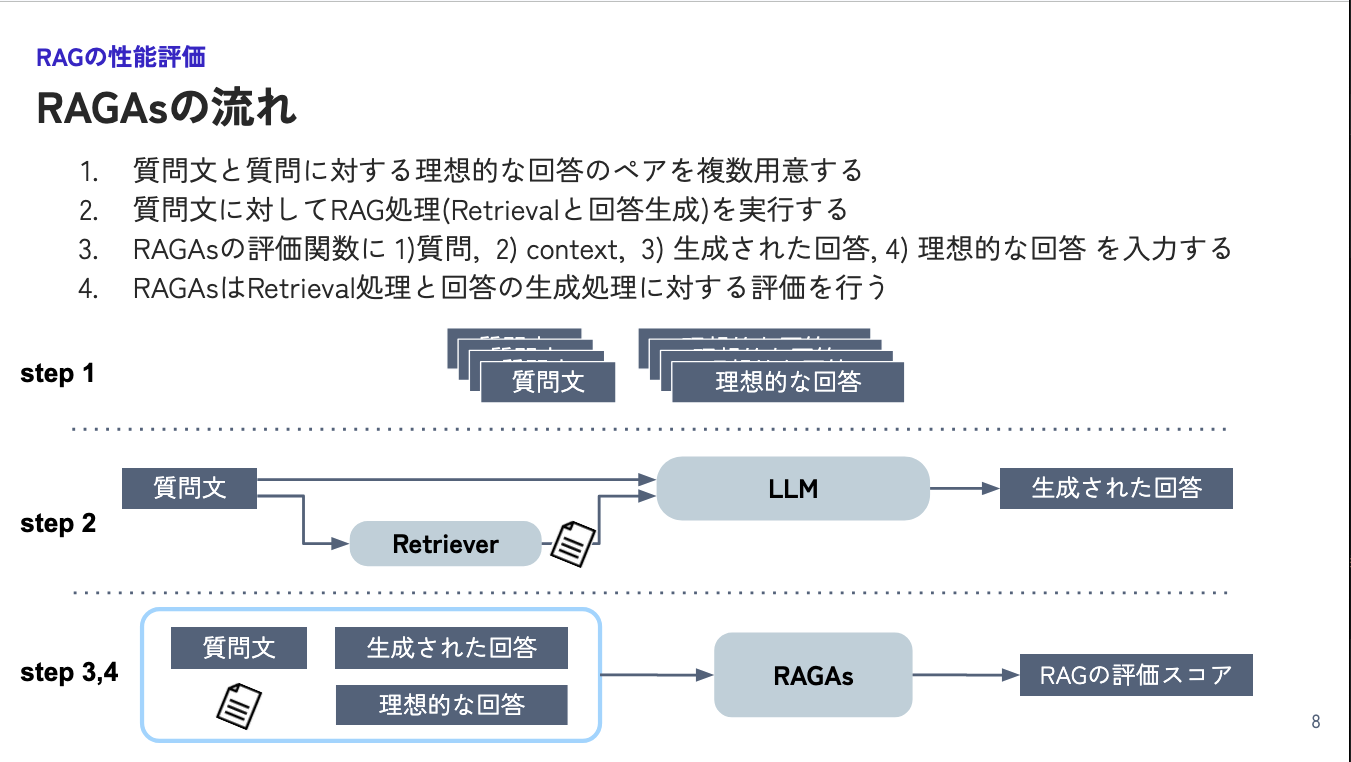

## 質問文と質問に対する理想的な回答のペアを複数用意する


In [ ]:
# 質問集
questions = ["この講義はどういうものですか？",
             "主催者はどういう団体ですか？",
             "合計何回の講義がありますか？",
             "講義日程はどうなってますか？",
             "参加したい場合はどうすれば良いですか？",
             "担当者の連絡先を教えてください",
             "参加費はいくらですか？",
             "何か事前準備は必要ですか？"]

# 理想的な回答
ideal_answers = ["この講義はRAGについて学ぶ講義です。",
                 "主催者はAI人材の育成に取り組んでいるLabdemyという団体です。",
                 "講義は合計4回です。",
                 "講義日程は：\n 第1回 2/2 (日) 14:00~15:30 \n 第2回 2/9 (日) 14:00~15:30 \n 第3回 2/16 (日) 14:00~15:30 \n 第4回 2/23 (日) 14:00~15:30 \nです。",
                 "参加したい場合はこちらの[リンク](https://discord.gg/JaQPZ5Gx?event=1323252933327847464)からdiscordサーバーに参加してください。",
                 "担当者の連絡先はlecture@labdemy.comです。",
                 "参加費は無料です。",
                 "事前準備はPython環境の準備、基礎的なプログラミング知識が必要です。"]

## 質問文に対してRAG処理(Retrievalと回答生成)を実行する

In [ ]:
from langchain.chat_models import ChatOpenAI
from tqdm import tqdm

# モデルの準備
chat_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

# チャット履歴
chat_history = [] #これはずっと空っぽのまま

# コンテキスト情報
contexts = []

# LLMの回答
model_answers = []

# 各質問に対して回答を生成し、それを記録していく
for question in tqdm(questions):
  context = get_context_from_db(vector_db,question)
  # contextから、文章のみを抽出して記録する
  context_text = [item[0].page_content for item in context]
  contexts.append(context_text)

  final_prompt,_ = format_prompt(context, question,chat_history)
  response = chat_model.invoke(final_prompt)
  # モデルの回答を記録
  model_answers.append(response.content)

<ipython-input-8-6274483e4634>:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat_model = ChatOpenAI(model_name="gpt-4", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


## RAGAs評価

In [ ]:
#評価データセット作成
from datasets import Dataset

eval_dataset_dict = {
  "user_input": questions, #質問集
  "response": model_answers, #LLMの回答
  "retrieved_contexts": contexts, #コンテキスト情報
  "reference": ideal_answers #理想的な回答
}

eval_dataset = Dataset.from_dict(eval_dataset_dict)

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

In [ ]:
# 評価用モデルの準備
evaluator_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

scores = evaluate(
    dataset=eval_dataset,
    metrics=[context_precision,context_recall,answer_relevancy,faithfulness],
    llm=evaluator_model
)

print(scores)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

{'context_precision': 0.6667, 'context_recall': 0.8125, 'answer_relevancy': 0.7192, 'faithfulness': 0.9375}


**評価値の解釈(復習)：**

retreivalに対する評価
- context precision: 検索して取り出した情報のうち、本当に役に立った情報の割合
- context recall: 必要な情報をどれくらい取りこぼさずに取得できたか

回答に対する評価
- answer relevancy: 質問に対してどれくらい良い回答になってるか
- faithfulness: context情報への「忠実性」を測る指標



In [ ]:
# 各質問に対する評価値を個別で見ることも可能
scores['context_precision']

[0.499999999975,
 0.0,
 0.8333333332916666,
 0.9999999999,
 0.49999999995,
 0.49999999995,
 0.9999999999,
 0.9999999999]

In [ ]:
# 一つ一つの質問に対する評価を見ていく
for question,model_answer,context,ideal_answer,cp,cr,ar,ft in zip(questions,model_answers,contexts,ideal_answers,scores['context_precision'],scores['context_recall'],scores['answer_relevancy'],scores['faithfulness']):
  print("="*20)
  print("\n【元々の質問】\n",question,"\n")
  print("【context情報】")
  for c in context:
    print('-',c)
  print("\n")
  print("【LLMの回答】\n",model_answer,"\n")
  print("【理想的な回答】\n",ideal_answer,"\n")
  print(f"【評価】\n cp:{cp:.2f}, cr:{cr:.2f}, ar:{ar:.2f}, ft:{ft:.2f} \n")


【元々の質問】
 この講義はどういうものですか？ 

【context情報】
- 講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に
- 務課題の経験を通して真に AI を活⽤できる⼈材の育成に取り組んでいます。
講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付
- 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
- この度は、 Labdemy の RAG （ Retrieval-Augmented Generation ）講義のテスト受講に
ご興味を⽰していただき、誠にありがとうございます！
- RA G 講 義 の テ ス ト 受 講 案 内
1
R A G 講義のテスト受講案内


【LLMの回答】
 Assistant: 
この講義は、RAG（Retrieval-Augmented Generation）について網羅的に学ぶものです。合計4回の講義を通じて、AIを活用できる人材の育成に取り組んでいます。講義は全てオンラインで行われ、Zoomリンクを通じて参加することができます。 

【理想的な回答】
 この講義はRAGについて学ぶ講義です。 

【評価】
 cp:0.50, cr:1.00, ar:0.77, ft:1.00 


【元々の質問】
 主催者はどういう団体ですか？ 

【context情報】
- 必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
- 第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
- RA G 講 義 の テ ス ト 受 講 案 内
3
講義期間中のサポート体制について
- この度は、 Labdemy の RAG （ Retrieval-Augmented Generat

# RAGAs基づくchunk sizeの最適化（第3回講義）

**chunk sizeとは (復習)**

参照情報を切り分ける際の一つ一つのchunkの大きさ
```python
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
   separators=["\n\n", "\n", " ", ""],#分割の基準となる文字
   chunk_size=200,		#chunkの大きさ
   chunk_overlap=20,	#chunkの重複の大きさ
   length_function=len,	#chunkの大きさの測定関数
   keep_separator=False #分割基準の文字を保持するか否か
)

docs = load_PDFs_from_dir('/content/sample_data/')
chunks = text_splitter.split_documents(docs)


```

In [ ]:
from datasets import Dataset

# 質問集
questions = ["この講義はどういうものですか？",
             "主催者はどういう団体ですか？",
             "合計何回の講義がありますか？",
             "講義日程はどうなってますか？",
             "参加したい場合はどうすれば良いですか？",
             "担当者の連絡先を教えてください",
             "参加費はいくらですか？",
             "何か事前準備は必要ですか？"]

# 理想的な回答
ideal_answers = ["この講義はRAGについて学ぶ講義です。",
                 "主催者はAI人材の育成に取り組んでいるLabdemyという団体です。",
                 "講義は合計4回です。",
                 "講義日程は：\n 第1回 2/2 (日) 14:00~15:30 \n 第2回 2/9 (日) 14:00~15:30 \n 第3回 2/16 (日) 14:00~15:30 \n 第4回 2/23 (日) 14:00~15:30 \nです。",
                 "参加したい場合はこちらの[リンク](https://discord.gg/JaQPZ5Gx?event=1323252933327847464)からdiscordサーバーに参加してください。",
                 "担当者の連絡先はlecture@labdemy.comです。",
                 "参加費は無料です。",
                 "事前準備はPython環境の準備、基礎的なプログラミング知識が必要です。"]

In [ ]:
chunk_sizes = [50, 100, 200, 300, 400, 500]
chunk_scores = []
eval_dataset_dicts = []

for chunk_size in tqdm(chunk_sizes):

  # chunk分けとベクトルDBへの保存
  documents = load_PDF("/content/RAG-lecture-lesson1/sample_files")
  chunks = create_chunks(documents=documents, chunk_size=chunk_size, chunk_overlap=0)
  embedding_model= OpenAIEmbeddings(model='text-embedding-3-small')
  vector_db = init_vector_db(embedding_model=embedding_model,db_path="database")
  vector_db.add_documents(documents=chunks)

  # 回答の生成
  chat_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
  chat_history,contexts, model_answers = [], [], []
  for question in questions:
    context = get_context_from_db(vector_db,question)
    context_text = [item[0].page_content for item in context]
    contexts.append(context_text)
    final_prompt,_ = format_prompt(context, question,chat_history)
    response = chat_model.invoke(final_prompt)
    model_answers.append(response.content)

  # 評価用データセットの作成
  eval_dataset_dict = {
    "user_input": questions, #質問集
    "response": model_answers, #LLMの回答
    "retrieved_contexts": contexts, #コンテキスト情報
    "reference": ideal_answers #理想的な回答
  }
  eval_dataset_dicts.append(eval_dataset_dict)

  eval_dataset = Dataset.from_dict(eval_dataset_dict)

  # 評価用モデルの準備
  evaluator_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])

  scores = evaluate(
      dataset=eval_dataset,
      metrics=[context_precision,context_recall,answer_relevancy,faithfulness],
      llm=evaluator_model
  )

  chunk_scores.append(scores)


  0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:39<03:16, 39.23s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [01:21<02:43, 40.84s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 3/6 [02:12<02:17, 45.75s/it]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [03:01<01:34, 47.04s/it]WARNING:chromadb.segment.impl.vector.local_persistent_hnsw:Number of requested results 5 is greater than number of elements in index 4, updating n_results = 4


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [03:53<00:48, 48.80s/it]WARNING:chromadb.segment.impl.vector.local_persistent_hnsw:Number of requested results 5 is greater than number of elements in index 4, updating n_results = 4


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 6/6 [04:45<00:00, 47.64s/it]


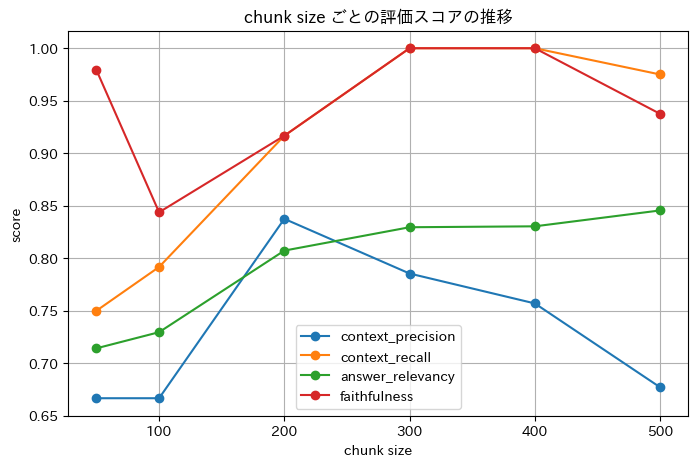

In [ ]:
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

metrics = ['context_precision','context_recall','answer_relevancy','faithfulness']

# x軸の定義
x_values = chunk_sizes

# 描写の準備
plt.figure(figsize=(8, 5))

# 各評価指標を別々の線として描写
for metric in metrics:
    y_values = [sum(item[metric])/len(item[metric]) for item in chunk_scores]  # 各評価指標の値を取得
    plt.plot(x_values, y_values, marker='o', label=metric)  # 線を描写

# ラベル等の設定
plt.xlabel("chunk size")
plt.ylabel("score")
plt.title("chunk size ごとの評価スコアの推移")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# chunk size 300 の時の 4番目の質問について見てみる
print("="*20)
print("\n【元々の質問】\n",eval_dataset_dicts[3]['user_input'][3],"\n")
print("【理想的な回答】\n",eval_dataset_dicts[3]['reference'][3],"\n")
print("【context情報】")
for c in eval_dataset_dicts[3]['retrieved_contexts'][3]:
  print('-',c)
print("\n")
print("【LLMの回答】\n",eval_dataset_dicts[3]['response'][3],"\n")

print(f"【評価】\n cp:{chunk_scores[3]['context_precision'][3]:.2f}, cr:{chunk_scores[3]['context_recall'][3]:.2f}, ar:{chunk_scores[3]['answer_relevancy'][3]:.2f}, ft:{chunk_scores[3]['faithfulness'][3]:.2f} \n")


【元々の質問】
 講義日程はどうなってますか？ 

【理想的な回答】
 講義日程は：
 第1回 2/2 (日) 14:00~15:30 
 第2回 2/9 (日) 14:00~15:30 
 第3回 2/16 (日) 14:00~15:30 
 第4回 2/23 (日) 14:00~15:30 
です。 

【context情報】
- RA G 講 義 の テ ス ト 受 講 案 内
1
R A G 講義のテスト受講案内
この度は、 Labdemy の RAG （ Retrieval-Augmented Generation ）講義のテスト受講に
ご興味を⽰していただき、誠にありがとうございます！
L a b d e m y について
Labdemy では、最先端の AI を研究レベルでマスターすることを⽬的に、深い学びと実
務課題の経験を通して真に AI を活⽤できる⼈材の育成に取り組んでいます。
講義概要
合計 4 回の講義に渡って RAG について網羅的に勉強していただきます。最終的には添付
- 第 1 回  2/2  ⽇  14001530
第 2 回  2/9  ⽇  14001530
第 3 回  2/16  ⽇  14001530
第 4 回  2/23  ⽇  14001530
参加⽅法： Zoom リンク（後⽇共有） ※ 講義は全てオンラインで⾏います。
必要な準備： Python 環境の準備、基礎的なプログラミング知識
参加費⽤：無料
参加⽅法
RAG 講義のテスト受講⽤ discord サーバーにご参加ください。（招待リンクは別途
添付）
Join the Labdemy School Beta Discord Server!
- RA G 講 義 の テ ス ト 受 講 案 内
3
講義期間中のサポート体制について
講義期間中は、 #lecture-test-rag-qa チャンネルにて質問を承ります！  @lectur ers  に
メンションを付けて質問をしてください。可能な限り迅速に回答いたしますが、質問内
容に応じて返信に時間がかかる場合がございます。
お問い合わせ先
もしご質問等ございましたら、  lecture@labdemy.com 宛にご連絡ください。
- RA G 講 義 の テ ス